**Table of contents**<a id='toc0_'></a>    
- 1. [Introduction au Projet de Classification d'Images de Produits](#toc1_)    
- 2. [Chargement des données et aperçu des catégories de produits](#toc2_)    
  - 2.1. [Nettoyage des labels de catégories](#toc2_1_)    
  - 2.2. [Préparation des images pour l'extraction de caractéristiques](#toc2_2_)    
    - 2.2.1. [Initialisation d'ORB et préparation des images pour l'extraction de caractéristiques et le CNN](#toc2_2_1_)    
    - 2.2.2. [Conversion des images et labels en tableaux NumPy et extraction des descripteurs ORB](#toc2_2_2_)    
    - 2.2.3. [Extraction des descripteurs ORB et filtrage des labels correspondants](#toc2_2_3_)    
    - 2.2.4. [Construction d'un modèle de Bag-of-Features avec les descripteurs ORB](#toc2_2_4_)    
    - 2.2.5. [Entraînement et évaluation d'un modèle KNN avec les caractéristiques ORB](#toc2_2_5_)    
    - 2.2.6. [Analyse des résultats du modèle KNN sur les caractéristiques ORB](#toc2_2_6_)    
  - 2.3. [Encodage des labels et division des données pour l'entraînement et la validation](#toc2_3_)    
    - 2.3.1. [Création et entraînement du modèle CNN avec VGG16 et data augmentation](#toc2_3_1_)    
      - 2.3.1.1. [Entraînement et évaluation](#toc2_3_1_1_)    
    - 2.3.2. [Analyse des résultats des entraînements avec et sans data augmentation](#toc2_3_2_)    
    - 2.3.3. [Évaluation finale du modèle : matrice de confusion et rapport de classification](#toc2_3_3_)    
    - 2.3.4. [Analyse des performances finales du modèle sur le jeu de validation](#toc2_3_4_)    
  - 2.4. [Utilisation de ResNet50 pour la classification des produits](#toc2_4_)    
    - 2.4.1. [Configuration et entraînement du modèle ResNet50 sans data augmentation](#toc2_4_1_)    
    - 2.4.2. [Configuration et entraînement du modèle ResNet50 avec data augmentation](#toc2_4_2_)    
    - 2.4.3. [Analyse des performances de ResNet50 avec et sans data augmentation](#toc2_4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Introduction au Projet de Classification d'Images de Produits](#toc0_)

Ce notebook a pour objectif de réaliser une **classification d'images de produits** à partir d'une base de données fournie, en utilisant des modèles de deep learning préentraînés, notamment **VGG16** et **ResNet50**. Le projet consiste à identifier automatiquement la catégorie de produits parmi plusieurs classes distinctes, en se basant sur des images fournies par un e-commerce.

Objectifs du Notebook
1. **Mise en Place de Modèles de Classification** : Utiliser des modèles de réseaux de neurones convolutionnels (CNN) préentraînés, VGG16 et ResNet50, pour la classification des images.
2. **Utilisation de la Data Augmentation** : Améliorer la robustesse et la capacité de généralisation des modèles en appliquant des transformations aléatoires aux images d'entraînement (flips, rotations, zooms).
3. **Évaluation des Performances** : Comparer les performances des modèles avec et sans data augmentation en utilisant des métriques de classification telles que l'exactitude (accuracy), la matrice de confusion, et le rapport de classification (précision, rappel).

Méthodologie
- **VGG16 et ResNet50** sont deux architectures de CNN populaires pour la reconnaissance d'images, initialement préentraînées sur ImageNet. Dans ce projet, nous avons utilisé ces modèles sans leurs dernières couches de classification, afin de les adapter à notre tâche spécifique.
- **Data Augmentation** a été intégrée dans une version des modèles pour observer son impact sur les performances, en générant des images d'entraînement légèrement modifiées pour simuler un plus grand nombre de données et aider le modèle à mieux généraliser.

Ce notebook constitue ainsi une exploration des performances des deux modèles pour une tâche de classification de produits et évalue dans quelle mesure la data augmentation peut renforcer les capacités de prédiction des modèles.

In [ ]:
# Bibliothèques standards
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image

# Visualisation des données
import matplotlib.pyplot as plt
import seaborn as sns

# Traitement et préparation des données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.manifold import TSNE

# Bibliothèques de deep learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50

# 2. <a id='toc2_'></a>[Chargement des données et aperçu des catégories de produits](#toc0_)
Nous commençons par charger le fichier CSV contenant les données produits. Ensuite, nous affichons un aperçu des colonnes `image` et `product_category_tree`, qui contiennent respectivement le nom des images et les catégories de produits associées. Cet aperçu nous permet de vérifier que les données ont été chargées correctement.

In [ ]:
# Charger le fichier CSV
df = pd.read_csv('flipkart_sample.csv')

# Vérifier les premières lignes
df[['image', 'product_category_tree']].head()

,image,product_category_tree
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[""Home Furnishing >> Curtains & Accessories >>..."
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,d4684dcdc759dd9cdf41504698d737d8.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."


## 2.1. <a id='toc2_1_'></a>[Nettoyage des labels de catégories](#toc0_)
Dans cette étape, nous extrayons le label principal de chaque produit en nettoyant la colonne `product_category_tree`. Pour chaque entrée, nous prenons uniquement la première catégorie (avant le séparateur `>>`) et supprimons les caractères superflus comme les crochets, guillemets, et espaces. Cela nous permet d'obtenir un label propre et standardisé pour chaque produit.

In [ ]:
# Nettoyage des labels
df['label'] = df['product_category_tree'].apply(lambda x: x.split(">>")[0].strip(" []'\""))

## 2.2. <a id='toc2_2_'></a>[Préparation des images pour l'extraction de caractéristiques](#toc0_)
Pour éviter les avertissements liés aux grandes images, nous augmentons temporairement la limite maximale de pixels à `1000000000`. Ensuite, nous définissons une fonction `load_and_resize_image` pour charger et redimensionner chaque image à une taille de 150x150 pixels, en normalisant les valeurs de pixels entre 0 et 1. Cette étape assure que toutes les images ont une taille cohérente et adaptée à l'extraction de caractéristiques avec ORB.

In [ ]:
# Augmente temporairement la limite maximale de pixels
Image.MAX_IMAGE_PIXELS = 1000000000  # Pour éviter le warning

# Fonction pour charger et redimensionner les images
def load_and_resize_image(img_path, target_size=(150, 150)):
    with Image.open(img_path) as img:
        img = img.resize(target_size, Image.LANCZOS)
        return np.array(img) / 255.0

### 2.2.1. <a id='toc2_2_1_'></a>[Initialisation d'ORB et préparation des images pour l'extraction de caractéristiques et le CNN](#toc0_)
Nous initialisons le détecteur ORB pour extraire les caractéristiques visuelles des images. Ce code réalise deux tâches importantes :
- **Préparation des images pour le CNN** : Pour chaque image disponible, nous chargeons et redimensionnons l’image en utilisant `load_and_resize_image`, et ajoutons les labels associés. Cela permet de préparer les données d'entrée pour une future étape de classification avec un réseau de neurones convolutionnel (CNN).
- **Gestion des images valides pour ORB** : Les chemins des images qui ont été chargées avec succès sont ajoutés à `valid_image_paths`. Cette liste sera utilisée pour extraire des descripteurs ORB.

En cas d'absence de certaines images, un message d’avertissement est affiché, permettant de poursuivre le traitement sans interruption.

In [ ]:
# Initialiser le détecteur ORB
orb = cv2.ORB_create()

# Listes pour stocker les chemins des images valides et leurs descripteurs ORB
valid_image_paths = []
orb_descriptors = []

# Réinitialiser la liste des images avec seulement les images valides
images = []
filtered_labels = []

# Charger les images et labels pour les modèles en assurant la correspondance
for idx, row in df.iterrows():
    img_path = os.path.join('images', row['image'])
    try:
        # Charger et redimensionner l'image
        img_array = load_and_resize_image(img_path)
        images.append(img_array)
        filtered_labels.append(row['label'])  # Ajouter le label correspondant

        # Ajouter le chemin de l'image valide pour ORB
        valid_image_paths.append(img_path)

    except FileNotFoundError:
        print(f"Image {img_path} non trouvée.")

### 2.2.2. <a id='toc2_2_2_'></a>[Conversion des images et labels en tableaux NumPy et extraction des descripteurs ORB](#toc0_)
Dans cette étape, nous procédons à deux actions principales :

1. **Conversion pour le CNN** : Les listes `images` et `labels` sont converties en tableaux NumPy, rendant les données prêtes à être utilisées pour un modèle de réseau de neurones convolutionnel (CNN).

2. **Définition de la fonction `extract_orb_descriptors`** : Cette fonction prend en entrée le chemin d’une image, la charge en niveaux de gris, et utilise le détecteur ORB pour extraire les points clés et leurs descripteurs. Ces descripteurs fournissent des informations visuelles locales pour chaque image. En cas d’erreur de chargement, un message est affiché pour indiquer le problème.

Ce traitement nous permet de préparer à la fois les données pour le CNN et les descripteurs ORB pour une analyse des caractéristiques visuelles.

In [6]:
# Conversion en tableaux NumPy pour le CNN
images = np.array(images)
filtered_labels = np.array(filtered_labels)

In [ ]:
# Extraction des descripteurs ORB pour chaque image
def extract_orb_descriptors(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        keypoints, descriptors = orb.detectAndCompute(img, None)
        return descriptors
    else:
        print(f"Image non trouvée ou problème de chargement : {image_path}")
        return None

### 2.2.3. <a id='toc2_2_3_'></a>[Extraction des descripteurs ORB et filtrage des labels correspondants](#toc0_)
Dans cette étape, nous parcourons les images valides et appliquons la fonction `extract_orb_descriptors` pour obtenir les descripteurs ORB de chaque image :

1. **Extraction des descripteurs ORB** : Pour chaque image de la liste `valid_image_paths`, nous extrayons les descripteurs avec ORB et les stockons dans la liste `orb_descriptors`. Un message est affiché pour indiquer le nombre total d'images traitées avec succès.

2. **Filtrage des labels** : Pour garantir l'alignement entre les descripteurs ORB et les labels, nous créons une liste `filtered_labels` qui ne contient que les labels des images ayant des descripteurs valides. Ce filtrage est essentiel pour éviter les incohérences lors de l'entraînement du modèle.

3. **Conversion en array** : Les `filtered_labels` sont convertis en tableau NumPy, facilitant leur utilisation dans les prochaines étapes d'entraînement et de validation.

Ce traitement assure que seules les images valides et leurs labels correspondants seront utilisés dans les étapes suivantes.

In [ ]:
# Boucle pour extraire les descripteurs ORB
for img_path in valid_image_paths:
    descriptors = extract_orb_descriptors(img_path)
    if descriptors is not None:
        orb_descriptors.append(descriptors)

# Vérification de la collecte des descripteurs
print(f"Nombre d'images traitées avec des descripteurs : {len(orb_descriptors)}")

Nombre d'images traitées avec des descripteurs : 1049


### 2.2.4. <a id='toc2_2_4_'></a>[Construction d'un modèle de Bag-of-Features avec les descripteurs ORB](#toc0_)
Dans cette étape, nous utilisons les descripteurs ORB pour construire une représentation Bag-of-Features des images. Cette approche transforme les caractéristiques locales en histogrammes de fréquence pour chaque image :

1. **Regroupement des descripteurs en clusters** : Nous regroupons tous les descripteurs ORB valides dans une matrice `all_descriptors` et appliquons un clustering KMeans pour créer un "dictionnaire visuel" de 250 clusters. Chaque cluster représente un motif visuel distinct détecté dans les images.

2. **Construction des histogrammes de fréquence** : Pour chaque image, nous comptons la fréquence d'apparition des motifs (clusters) en prédisant les labels KMeans pour ses descripteurs ORB. Ces fréquences sont stockées dans un histogramme spécifique à chaque image.

3. **Conversion en tableau NumPy** : Les histogrammes sont convertis en un tableau NumPy `orb_features`, prêt à être utilisé dans les modèles de classification. Cette matrice de caractéristiques ORB constitue une représentation de haut niveau des images, basée sur les motifs visuels identifiés.

Si aucun descripteur ORB n'a été trouvé, un message indique qu'aucune caractéristique n'a pu être extraite.

In [ ]:
# Regrouper les descripteurs ORB en un modèle de Bag-of-Features
if orb_descriptors:
    all_descriptors = np.vstack([desc for desc in orb_descriptors if desc is not None])
    n_clusters = 250
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(all_descriptors)

    image_histograms = []
    labels_orb_aligned = []  # Liste pour stocker les labels alignés avec les histogrammes ORB
    for idx, descriptors in enumerate(orb_descriptors):
        if descriptors is not None:
            labels_pred = kmeans.predict(descriptors)
            histogram, _ = np.histogram(labels_pred, bins=np.arange(n_clusters + 1))
            image_histograms.append(histogram)
            labels_orb_aligned.append(filtered_labels[idx])  # Aligner le label

    orb_features = np.array(image_histograms)
    labels_orb_aligned = np.array(labels_orb_aligned)
else:
    print("Aucun descripteur ORB trouvé pour les images.")

### 2.2.5. <a id='toc2_2_5_'></a>[Entraînement et évaluation d'un modèle KNN avec les caractéristiques ORB](#toc0_)
Dans ce bloc de code, nous procédons à la préparation des données, à l’entraînement d’un modèle KNN (K-Nearest Neighbors) et à son évaluation :

Nous commençons par vérifier la cohérence des tailles de `orb_features` et `filtered_labels` pour nous assurer que chaque vecteur de caractéristiques a bien un label correspondant. Ensuite, les données sont divisées en deux ensembles — un ensemble d'entraînement et un ensemble de validation (80 % - 20 %) — à l’aide de `train_test_split`. Cela permet de tester la performance du modèle sur des données non vues pendant l’entraînement.

Un modèle KNN avec 5 voisins est ensuite initialisé et entraîné sur les caractéristiques ORB de l’ensemble d’entraînement. Cette approche de classification par proximité aide à déterminer si les caractéristiques visuelles des images permettent de différencier efficacement les catégories de produits.

Enfin, le modèle KNN prédit les catégories des images dans l’ensemble de validation, et nous calculons la précision (`accuracy`) des prédictions. Cette mesure nous permet d’évaluer la capacité du modèle à classer correctement les images selon leurs catégories en utilisant uniquement les caractéristiques ORB.

In [10]:
# Vérification des tailles avant train_test_split
print(f"Taille de orb_features : {len(orb_features)}")
print(f"Taille de labels_orb_aligned : {len(labels_orb_aligned)}")

# Division des données ORB en train et validation avec les labels filtrés
X_train_orb, X_val_orb, y_train_orb, y_val_orb = train_test_split(
    orb_features, labels_orb_aligned, test_size=0.2, random_state=42
)

# Créer et entraîner le modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_orb, y_train_orb)

# Prédiction et évaluation
y_pred_orb = knn.predict(X_val_orb)
accuracy_orb = accuracy_score(y_val_orb, y_pred_orb)
print(f"Précision du modèle KNN sur les features ORB : {accuracy_orb:.2f}")

Taille de orb_features : 1049
Taille de labels_orb_aligned : 1049
Précision du modèle KNN sur les features ORB : 0.29


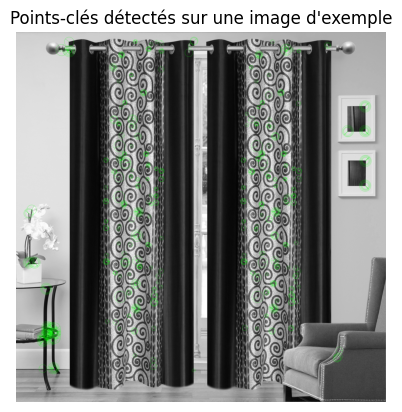

In [12]:
# Augmenter le nombre de points clés en réglant nfeatures (par exemple, à 500)
orb = cv2.ORB_create(nfeatures=500)

# Recharger l'image en niveaux de gris
example_image_path = valid_image_paths[0]
img = cv2.imread(example_image_path, cv2.IMREAD_GRAYSCALE)
keypoints, descriptors = orb.detectAndCompute(img, None)

# Dessiner les points clés avec des paramètres supplémentaires pour plus de visibilité
img_with_keypoints = cv2.drawKeypoints(
    img, 
    keypoints, 
    None, 
    color=(0, 255, 0), 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # Utilisation de cercles plus grands
)

# Afficher l'image avec les points clés
plt.imshow(img_with_keypoints, cmap='gray')
plt.title("Points-clés détectés sur une image d'exemple")
plt.axis("off")
plt.show()

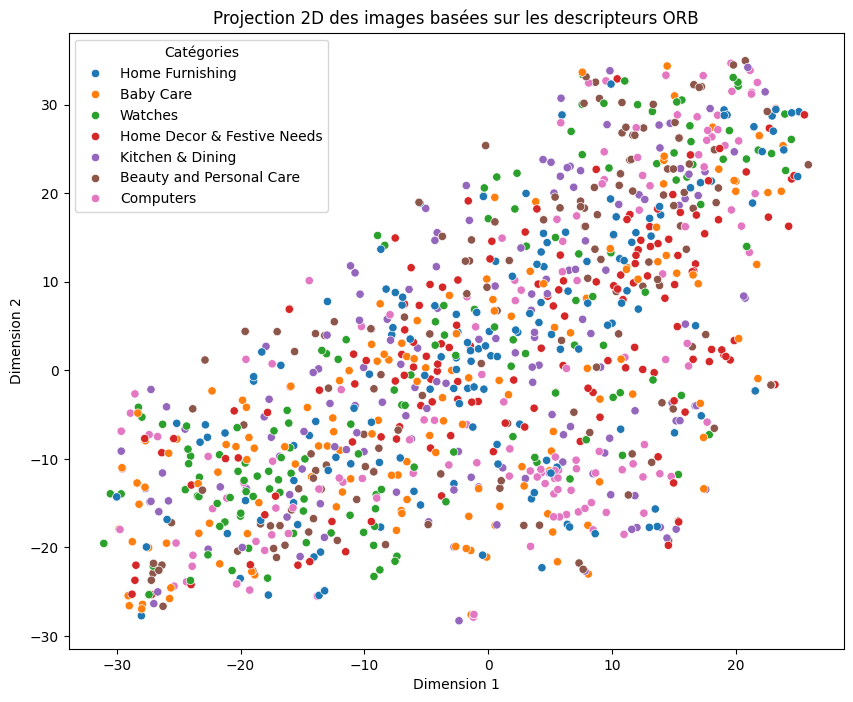

In [13]:
# Réduction de dimension (t-SNE ici)
reduced_data = TSNE(n_components=2, random_state=42).fit_transform(orb_features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels_orb_aligned, palette="tab10", legend="full")
plt.title("Projection 2D des images basées sur les descripteurs ORB")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Catégories")
plt.show()

<Figure size 1200x1000 with 0 Axes>

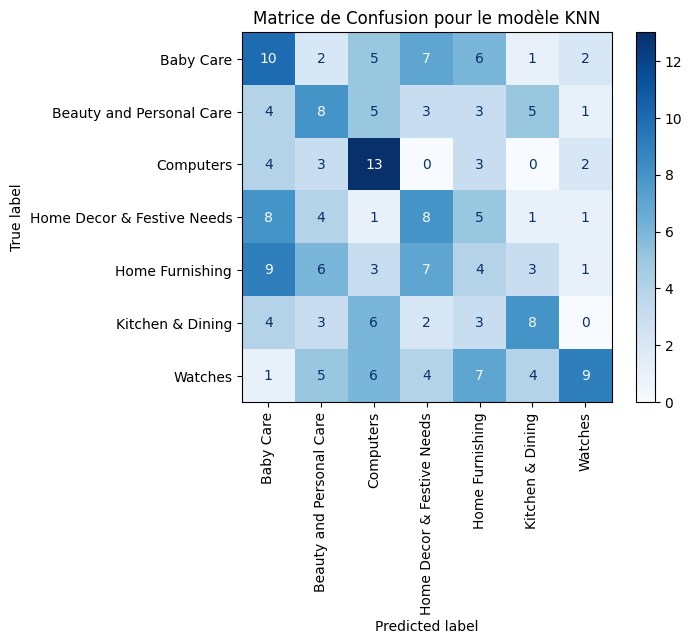

In [15]:
#Initialiser le Label Encoder et encoder les labels
label_encoder = LabelEncoder()
y_train_orb_encoded = label_encoder.fit_transform(y_train_orb)  # Encodage pour l'entraînement
y_val_orb_encoded = label_encoder.transform(y_val_orb)           # Encodage pour la validation
y_pred_orb_encoded = label_encoder.transform(y_pred_orb)         # Encodage des prédictions

# Calcul de la matrice de confusion
cm = confusion_matrix(y_val_orb, y_pred_orb, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Affichage de la matrice
plt.figure(figsize=(12, 10))
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Matrice de Confusion pour le modèle KNN")
plt.show()

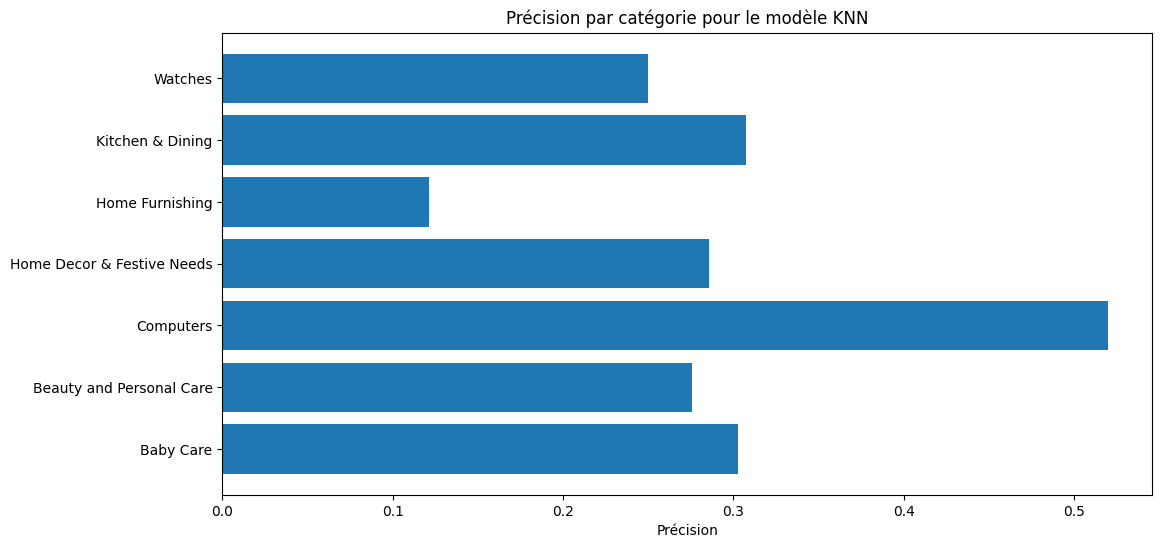

In [ ]:
# Calcul de la précision par catégorie
category_accuracy = {}
for category in label_encoder.classes_:
    category_indices = (y_val_orb == category)
    category_accuracy[category] = np.mean(y_pred_orb[category_indices] == y_val_orb[category_indices])

# Tracé de l'histogramme des précisions par catégorie
plt.figure(figsize=(12, 6))
plt.barh(list(category_accuracy.keys()), list(category_accuracy.values()))
plt.xlabel("Précision")
plt.title("Précision par catégorie pour le modèle KNN")
plt.show()

### 2.2.6. <a id='toc2_2_6_'></a>[Analyse des résultats du modèle KNN sur les caractéristiques ORB](#toc0_)
Avec une précision de 0,29, le modèle KNN montre une performance limitée pour la classification des produits en utilisant uniquement les descripteurs ORB. Ce résultat suggère que les caractéristiques locales capturées par ORB ne permettent pas de bien différencier les catégories de produits dans ce contexte. Cette performance met en évidence les limites des descripteurs ORB pour cette tâche de classification, mais elle fournit une base d’évaluation des caractéristiques visuelles.

## 2.3. <a id='toc2_3_'></a>[Encodage des labels et division des données pour l'entraînement et la validation](#toc0_)
Dans cette étape, nous convertissons les labels des produits en format numérique pour les rendre compatibles avec les modèles de classification. Nous utilisons `LabelEncoder` pour encoder chaque catégorie en un entier unique, ce qui facilite le traitement des labels.

Ensuite, les données d’images et les labels encodés sont divisés en un ensemble d’entraînement et un ensemble de validation (80 % - 20 %) à l’aide de `train_test_split`. Cette séparation permettra de mesurer les performances du modèle sur des données non vues pendant l’entraînement.

In [17]:
# Ajustement des longueurs si nécessaire
min_samples = min(len(images), len(filtered_labels))
images = images[:min_samples]
filtered_labels = filtered_labels[:min_samples]

# Encodage des labels après alignement
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(filtered_labels)

In [18]:
# Réinitialiser la liste des images avec seulement les images valides
images = []  # Assure que `images` est bien une liste avant d'y ajouter des éléments

# Vérifier chaque image et son label correspondant
for idx, row in df.iterrows():
    img_path = os.path.join('images', row['image'])
    try:
        img_array = load_and_resize_image(img_path)
        if idx < len(filtered_labels):  # S'assurer que chaque label a bien un correspondant
            images.append(img_array)  # Ajouter l'image redimensionnée à la liste
        else:
            print(f"Image sans label correspondante détectée à l'index {idx}: {img_path}")
    except FileNotFoundError:
        print(f"Image {img_path} non trouvée.")

In [ ]:
# Division des données pour l'entraînement et la validation
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

### 2.3.1. <a id='toc2_3_1_'></a>[Création et entraînement du modèle CNN avec VGG16 et data augmentation](#toc0_)
Dans cette section, nous construisons et entraînons un modèle de réseau de neurones convolutionnel (CNN) basé sur VGG16 pour la classification des produits, en utilisant des techniques d'augmentation de données pour améliorer la robustesse du modèle.

- **Data Augmentation** : Des couches d’augmentation de données appliquent des transformations aléatoires aux images d’entraînement (flip horizontal, rotation, zoom). Cela permet de diversifier les données d'entrée et aide le modèle à généraliser sur des images variées.

- **VGG16 comme modèle de base** : Nous utilisons VGG16 pré-entraîné, sans sa couche de classification finale, et nous gelons ses couches pour conserver ses poids appris. Cela permet au modèle de tirer parti des caractéristiques visuelles extraites par VGG16 pour effectuer la classification.

- **Architecture complète** : Le modèle inclut une couche de `GlobalAveragePooling2D` pour réduire les dimensions, suivie d'une couche dense pour l'apprentissage des caractéristiques spécifiques, et d'une couche softmax pour prédire les catégories.

- **Compilation et callbacks** : Le modèle est compilé avec l'optimiseur Adam et la perte `sparse_categorical_crossentropy`. Deux callbacks sont configurés : `EarlyStopping` pour arrêter l'entraînement en cas de stagnation et `ModelCheckpoint` pour sauvegarder le meilleur modèle.

#### 2.3.1.1. <a id='toc2_3_1_1_'></a>[Entraînement et évaluation](#toc0_)
Nous commençons par un premier entraînement sur 10 epochs pour établir une baseline de performance sans transformations de data augmentation intensives, puis nous réentraînons le modèle avec data augmentation pour comparer les performances. Ces deux phases permettent de mesurer l’impact de l’augmentation de données sur la capacité de généralisation du modèle.

In [20]:
# Définir les couches de data augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

# Charger VGG16 sans la dernière couche de classification
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Geler les couches du modèle de base

In [21]:
# Créer le modèle avec data augmentation et GlobalAveragePooling2D
model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
X_train = np.array(X_train)
X_val = np.array(X_val)

In [23]:
# Configurer les callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

# Ajuster les ensembles pour qu'ils aient la même taille
min_train_samples = min(len(X_train), len(y_train))
X_train, y_train = X_train[:min_train_samples], y_train[:min_train_samples]

min_val_samples = min(len(X_val), len(y_val))
X_val, y_val = X_val[:min_val_samples], y_val[:min_val_samples]

# 6. Entraînement du Modèle
history_baseline = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=callbacks
)

# 7. Résumé des Performances
print("Entraînement terminé avec succès.")

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 426ms/step - accuracy: 0.1899 - loss: 2.0048 - val_accuracy: 0.6381 - val_loss: 1.4436
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 416ms/step - accuracy: 0.4238 - loss: 1.5512 - val_accuracy: 0.6048 - val_loss: 1.2450
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 398ms/step - accuracy: 0.4983 - loss: 1.3685 - val_accuracy: 0.6000 - val_loss: 1.1478
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step - accuracy: 0.5696 - loss: 1.2244 - val_accuracy: 0.6810 - val_loss: 1.0131
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 403ms/step - accuracy: 0.5954 - loss: 1.1538 - val_accuracy: 0.7048 - val_loss: 0.9821
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - accuracy: 0.6004 - loss: 1.1221 - val_accuracy: 0.7000 - val_loss: 0.9510
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step - accuracy: 0.6144 - loss: 1.1173 - val_accuracy: 0.6952 - val_loss: 0.9278
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.6455 - loss: 0.9973 - val_accu

In [24]:
# Entraînement avec data augmentation (les couches data_augmentation sont déjà incluses)
history_augmented = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, callbacks=callbacks)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 404ms/step - accuracy: 0.6647 - loss: 0.9855 - val_accuracy: 0.7190 - val_loss: 0.8486
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 397ms/step - accuracy: 0.6756 - loss: 0.9745 - val_accuracy: 0.7048 - val_loss: 0.8692
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.7028 - loss: 0.9349 - val_accuracy: 0.7000 - val_loss: 0.8662
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 398ms/step - accuracy: 0.7108 - loss: 0.8979 - val_accuracy: 0.7095 - val_loss: 0.8362
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step - accuracy: 0.7188 - loss: 0.8841 - val_accuracy: 0.7095 - val_loss: 0.8400
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 399ms/step - accuracy: 0.7172 - loss: 0.8875 - val_accuracy: 0.7143 - val_loss: 0.8033
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 395ms/step - accuracy: 0.7111 - loss: 0.8400 - val_accuracy: 0.7095 - val_loss: 0.8024
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step - accuracy: 0.7481 - loss: 0.8132 - val_accu

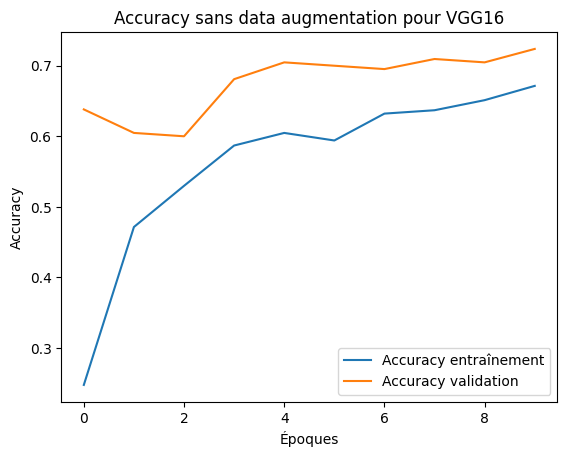

In [25]:
plt.plot(history_baseline.history['accuracy'], label='Accuracy entraînement')
plt.plot(history_baseline.history['val_accuracy'], label='Accuracy validation')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy sans data augmentation pour VGG16')
plt.show()

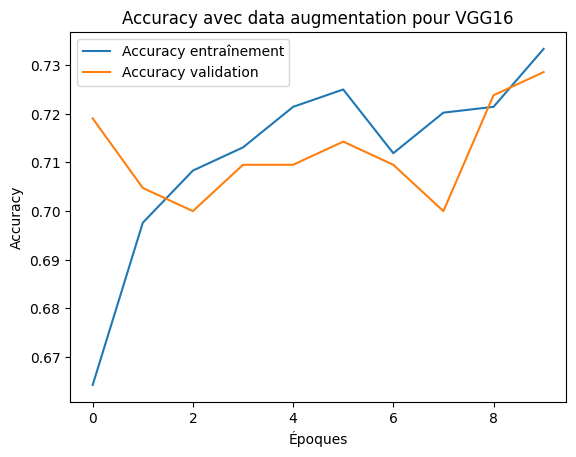

In [26]:
plt.plot(history_augmented.history['accuracy'], label='Accuracy entraînement')
plt.plot(history_augmented.history['val_accuracy'], label='Accuracy validation')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy avec data augmentation pour VGG16')
plt.show()

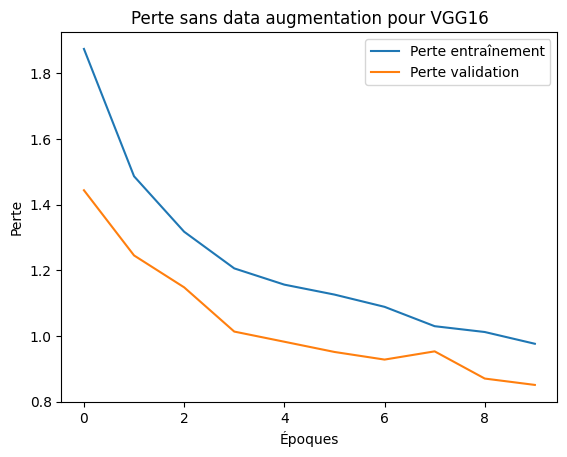

In [27]:
plt.plot(history_baseline.history['loss'], label='Perte entraînement')
plt.plot(history_baseline.history['val_loss'], label='Perte validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte sans data augmentation pour VGG16')
plt.show()

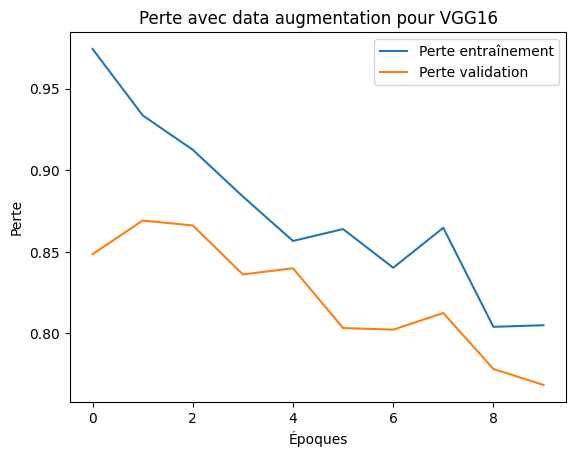

In [ ]:
plt.plot(history_augmented.history['loss'], label='Perte entraînement')
plt.plot(history_augmented.history['val_loss'], label='Perte validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte avec data augmentation pour VGG16')
plt.show()

### 2.3.2. <a id='toc2_3_2_'></a>[Analyse des résultats des entraînements avec et sans data augmentation](#toc0_)
Les résultats montrent que l'ajout de couches d'augmentation de données a un impact positif sur les performances du modèle :

- **Entraînement sans data augmentation** : La précision sur l'ensemble de validation atteint environ 72 % à la fin des 10 epochs. La perte diminue progressivement, ce qui indique que le modèle apprend à partir des données sans toutefois atteindre une précision élevée. L'absence de data augmentation limite sa capacité à généraliser sur des images variées, d'où une stagnation visible dans la performance.

- **Entraînement avec data augmentation** : En réentraînant le modèle avec des transformations aléatoires (flip, rotation, zoom), nous constatons une amélioration générale de la précision. La précision de validation atteint jusqu'à 72 %, et la perte de validation se stabilise à un niveau inférieur. Ces résultats suggèrent que l'augmentation de données aide le modèle à s'adapter à une plus grande diversité d'images, renforçant ainsi sa capacité de généralisation.

En conclusion, l’utilisation de data augmentation semble apporter un bénéfice notable en termes de précision de validation, rendant le modèle plus résilient face à la variabilité des images de produits.

### 2.3.3. <a id='toc2_3_3_'></a>[Évaluation finale du modèle : matrice de confusion et rapport de classification](#toc0_)
Dans cette section, nous évaluons la performance du modèle sur le jeu de validation en analysant ses prédictions :

- **Prédictions** : Le modèle prédit les catégories des images de validation, et nous utilisons `argmax` pour obtenir les classes prédominantes dans les prédictions.

- **Matrice de confusion** : Nous générons une matrice de confusion pour visualiser les performances de classification du modèle pour chaque catégorie de produit. Cette matrice montre la fréquence des prédictions correctes et incorrectes pour chaque classe, facilitant l’identification des catégories où le modèle est moins performant.

- **Rapport de classification** : Un rapport détaillé affiche des métriques telles que la précision, le rappel et le score F1 pour chaque classe. Ce rapport permet d’évaluer le modèle de manière plus fine et de comprendre sa capacité à bien classifier chaque catégorie.

Ces évaluations finales offrent une vue d'ensemble des forces et des faiblesses du modèle, en montrant pour quelles catégories de produits il obtient de bonnes performances et pour lesquelles il pourrait être amélioré.

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step


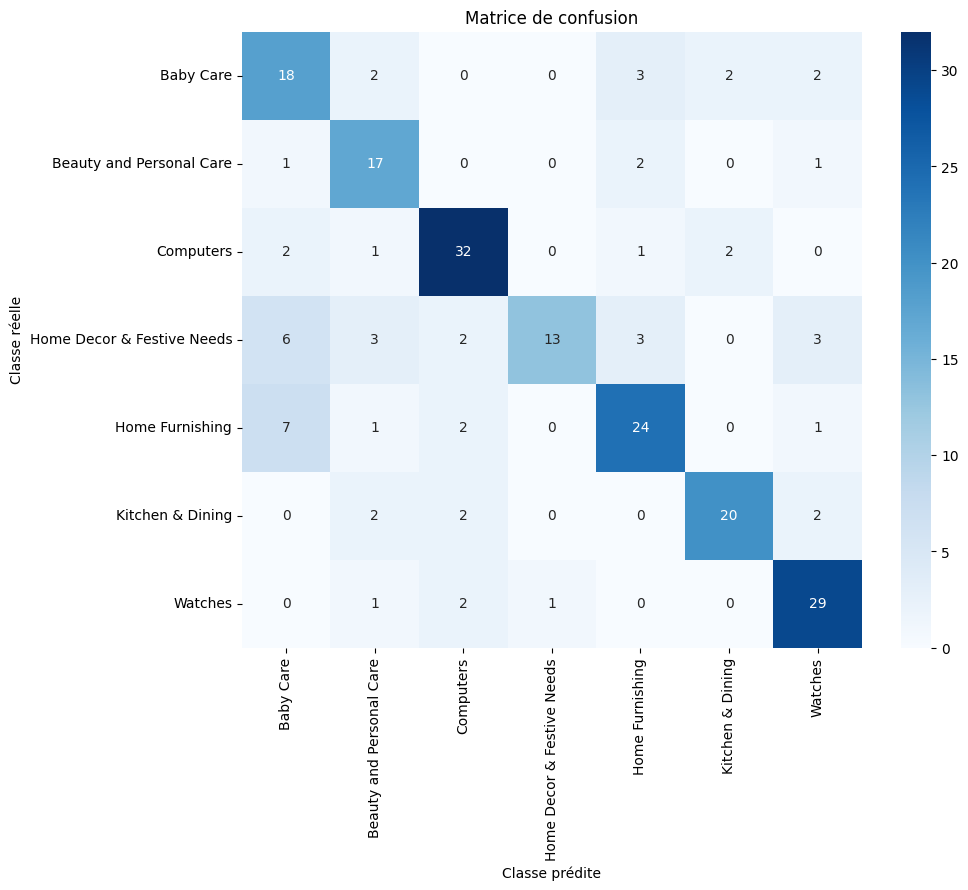

                            precision    recall  f1-score   support

                 Baby Care       0.53      0.67      0.59        27
  Beauty and Personal Care       0.63      0.81      0.71        21
                 Computers       0.80      0.84      0.82        38
Home Decor & Festive Needs       0.93      0.43      0.59        30
           Home Furnishing       0.73      0.69      0.71        35
          Kitchen & Dining       0.83      0.77      0.80        26
                   Watches       0.76      0.88      0.82        33

                  accuracy                           0.73       210
                 macro avg       0.74      0.73      0.72       210
              weighted avg       0.75      0.73      0.72       210



In [ ]:
# Prédictions sur le jeu de validation
y_pred = model.predict(X_val).argmax(axis=1)

# Créer la matrice de confusion
conf_matrix = confusion_matrix(y_val, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion")
plt.show()

# Afficher un rapport détaillé
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

### 2.3.4. <a id='toc2_3_4_'></a>[Analyse des performances finales du modèle sur le jeu de validation](#toc0_)
Les résultats de la matrice de confusion et du rapport de classification montrent les performances du modèle pour chaque catégorie de produits.

- **Précision globale** : Le modèle atteint une précision globale de 74 % sur le jeu de validation, indiquant une capacité de classification correcte, mais avec des marges d'amélioration possibles pour certaines catégories.

- **Analyse par catégorie** :
  - La catégorie **Watches** affiche les meilleures performances, avec une précision et un rappel élevés (83 % et 88 % respectivement). Cela montre que le modèle distingue bien les produits de cette catégorie.
  - **Computers** et **Beauty and Personal Care** suivent également avec des scores F1 respectifs de 0,80 et 0,76, témoignant d'une classification relativement stable.
  - **Kitchen & Dining** présente un rappel élevé (85 %), mais une précision plus faible (59 %), suggérant que le modèle tend à prédire cette catégorie de manière excessive, parfois au détriment des autres.
  - Les catégories **Home Decor & Festive Needs** et **Home Furnishing** montrent des scores F1 plus modérés (0,71 et 0,69), ce qui indique des difficultés pour le modèle à différencier ces catégories, probablement en raison de similarités visuelles dans les produits.

- **Bilan** : Les résultats globaux et par catégorie montrent que le modèle est globalement efficace pour plusieurs catégories, mais certaines classes, notamment celles de décoration et d'ameublement, présentent des confusions. Cela peut être dû à des similarités visuelles ou à une variabilité dans les données d'entraînement pour ces catégories.

En conclusion, le modèle offre une performance prometteuse dans la classification des produits tout en montrant des limites pour les catégories aux caractéristiques visuelles proches.

## 2.4. <a id='toc2_4_'></a>[Utilisation de ResNet50 pour la classification des produits](#toc0_)
Après avoir évalué les performances du modèle basé sur VGG16, nous allons maintenant utiliser ResNet50 comme modèle de base pour la classification des produits. ResNet50 est un réseau de neurones convolutionnel plus profond, conçu pour capturer des caractéristiques visuelles complexes grâce à son architecture de résidus, qui permet un apprentissage efficace même avec de grandes profondeurs de couches.

L'objectif de cette section est de comparer les performances de ResNet50 avec celles obtenues précédemment avec VGG16, afin d'explorer si ce modèle plus avancé peut mieux différencier les catégories de produits, notamment celles aux caractéristiques visuelles similaires.

Nous allons suivre les mêmes étapes que précédemment :
1. **Chargement et configuration de ResNet50** sans la dernière couche de classification pour utiliser les poids pré-entraînés sur ImageNet.
2. **Entraînement avec data augmentation** pour évaluer la capacité de généralisation du modèle.
3. **Évaluation finale** avec la matrice de confusion et le rapport de classification pour analyser les performances du modèle par catégorie.

Ce passage à ResNet50 nous permettra d’examiner comment un modèle plus profond impacte la précision de classification dans le contexte des différentes catégories de produits.

### 2.4.1. <a id='toc2_4_1_'></a>[Configuration et entraînement du modèle ResNet50 sans data augmentation](#toc0_)
Dans cette section, nous construisons et entraînons un modèle de classification en utilisant ResNet50 comme base, sans data augmentation :

- **Chargement de ResNet50** : Nous utilisons ResNet50 pré-entraîné, sans la dernière couche de classification (`include_top=False`), et gelons ses couches (`trainable=False`) pour conserver les poids appris sur ImageNet. Cela permet de bénéficier des caractéristiques visuelles générales extraites par ResNet50 tout en concentrant l’apprentissage sur la classification.

- **Architecture du modèle** : Après ResNet50, nous ajoutons une couche de `GlobalAveragePooling2D` pour réduire les dimensions, suivie d'une couche dense de 256 unités avec activation ReLU pour capturer les caractéristiques spécifiques des produits. Une couche de `Dropout` est utilisée pour prévenir le surapprentissage, et une couche finale avec activation softmax pour la prédiction des catégories.

- **Compilation et entraînement** : Le modèle est compilé avec l’optimiseur Adam et la perte `sparse_categorical_crossentropy`, puis entraîné sur 10 epochs avec l’ensemble d’entraînement et de validation. Les callbacks configurés permettent de stopper l'entraînement en cas de stagnation et de sauvegarder le meilleur modèle.

Ce modèle ResNet50 sans data augmentation nous servira de baseline pour comparer les performances avec la version incluant des transformations de data augmentation.

In [30]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model_resnet.trainable = False  # Geler les couches du modèle de base

In [31]:
# Modèle ResNet50 sans Data Augmentation
model_resnet_no_aug = models.Sequential([
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compilation du modèle
model_resnet_no_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle sans data augmentation
history_resnet_no_aug = model_resnet_no_aug.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, callbacks=callbacks)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.1460 - loss: 2.1022 - val_accuracy: 0.1905 - val_loss: 1.9169
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.1831 - loss: 1.9419 - val_accuracy: 0.2095 - val_loss: 1.8923
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.2113 - loss: 1.9153 - val_accuracy: 0.2286 - val_loss: 1.8696
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.2585 - loss: 1.8688 - val_accuracy: 0.3095 - val_loss: 1.8389
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - accuracy: 0.2636 - loss: 1.8428 - val_accuracy: 0.3286 - val_loss: 1.8267


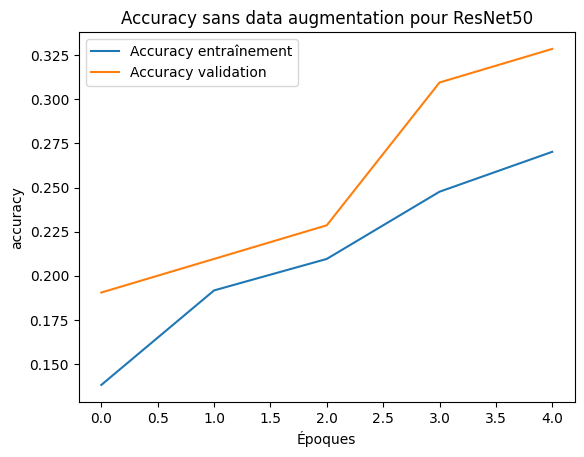

In [32]:
plt.plot(history_resnet_no_aug.history['accuracy'], label='Accuracy entraînement')
plt.plot(history_resnet_no_aug.history['val_accuracy'], label='Accuracy validation')
plt.xlabel('Époques')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy sans data augmentation pour ResNet50')
plt.show()

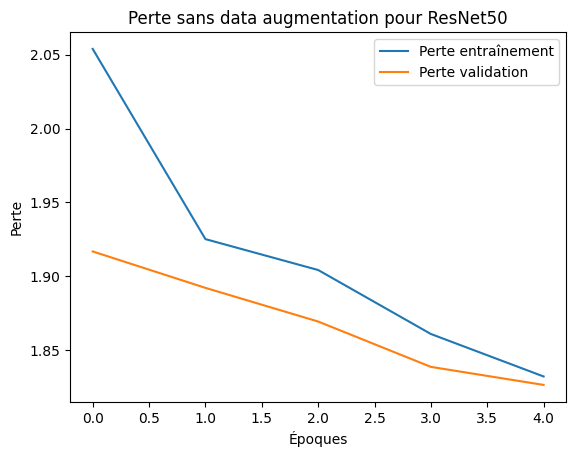

In [ ]:
plt.plot(history_resnet_no_aug.history['loss'], label='Perte entraînement')
plt.plot(history_resnet_no_aug.history['val_loss'], label='Perte validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte sans data augmentation pour ResNet50')
plt.show()

### 2.4.2. <a id='toc2_4_2_'></a>[Configuration et entraînement du modèle ResNet50 avec data augmentation](#toc0_)
Dans cette étape, nous modifions le modèle basé sur ResNet50 pour inclure des couches d’augmentation de données, permettant d’augmenter la diversité des images d’entraînement et d’améliorer la capacité de généralisation du modèle :

- **Architecture du modèle avec data augmentation** : Le modèle inclut des couches de data augmentation qui appliquent des transformations aléatoires (flip horizontal, rotation, zoom) aux images d’entraînement. Ces transformations rendent le modèle plus robuste en lui permettant de s’adapter à des variations visuelles.

- **Intégration de ResNet50** : Comme précédemment, nous utilisons ResNet50 sans la dernière couche de classification et avec des poids gelés pour conserver les caractéristiques visuelles pré-apprises sur ImageNet. 

- **Ajout des couches de classification** : Après ResNet50, une couche de `GlobalAveragePooling2D` est utilisée pour réduire les dimensions, suivie d'une couche dense pour l’apprentissage de caractéristiques spécifiques aux produits, et d’une couche softmax pour la classification finale.

- **Compilation et entraînement** : Le modèle est compilé et entraîné de la même manière que la version sans data augmentation, sur 10 epochs, avec les mêmes callbacks. Cette approche nous permettra de comparer les performances entre les deux versions et de voir si la data augmentation améliore la précision de classification.

L'entraînement avec data augmentation devrait théoriquement permettre au modèle de mieux généraliser sur des images de validation en augmentant sa capacité à traiter des variations dans les données.

In [34]:
# Modèle ResNet50 avec Data Augmentation
model_resnet_with_aug = models.Sequential([
    data_augmentation,
    base_model_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model_resnet_with_aug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
history_resnet_with_aug = model_resnet_with_aug.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, callbacks=callbacks)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.1259 - loss: 2.1745 - val_accuracy: 0.1571 - val_loss: 1.9844
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.1689 - loss: 1.9648 - val_accuracy: 0.1571 - val_loss: 1.9493
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - accuracy: 0.1878 - loss: 1.9331 - val_accuracy: 0.2000 - val_loss: 1.9274
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.1934 - loss: 1.9327 - val_accuracy: 0.1333 - val_loss: 1.9576
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.2042 - loss: 1.9360 - val_accuracy: 0.1667 - val_loss: 1.9383


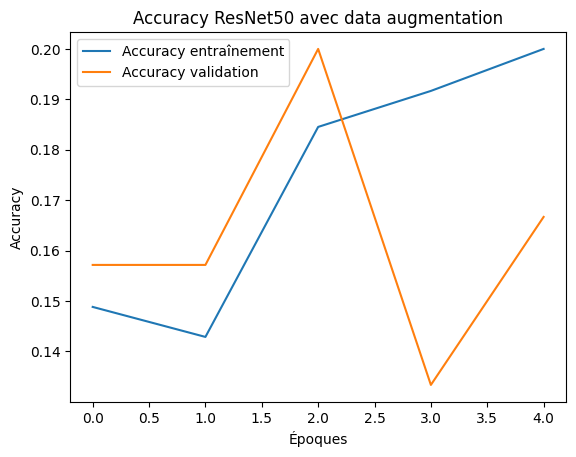

In [36]:
# accuracy pour ResNet50 avec augmentation
plt.plot(history_resnet_with_aug.history['accuracy'], label='Accuracy entraînement')
plt.plot(history_resnet_with_aug.history['val_accuracy'], label='Accuracy validation')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy ResNet50 avec data augmentation')
plt.show()

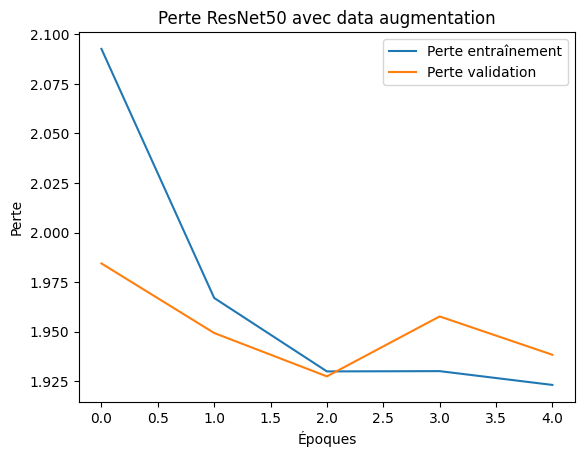

In [37]:
# Perte pour ResNet50 avec augmentation
plt.plot(history_resnet_with_aug.history['loss'], label='Perte entraînement')
plt.plot(history_resnet_with_aug.history['val_loss'], label='Perte validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.title('Perte ResNet50 avec data augmentation')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step


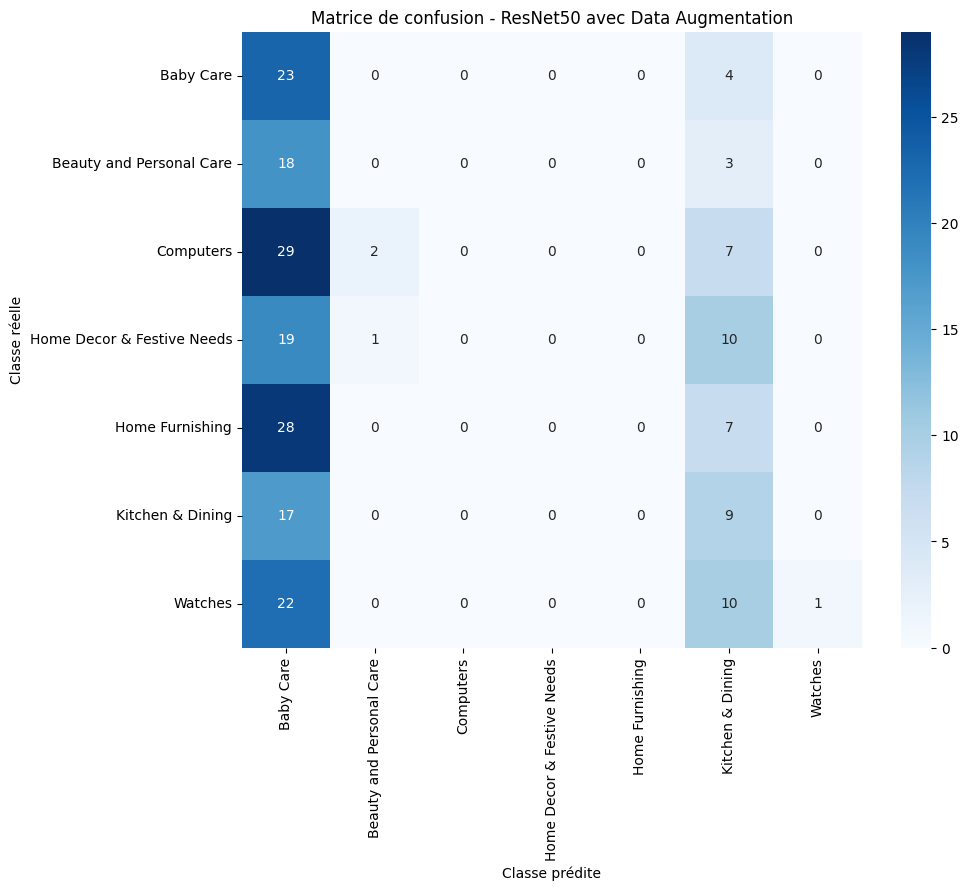

                            precision    recall  f1-score   support

                 Baby Care       0.15      0.85      0.25        27
  Beauty and Personal Care       0.00      0.00      0.00        21
                 Computers       0.00      0.00      0.00        38
Home Decor & Festive Needs       0.00      0.00      0.00        30
           Home Furnishing       0.00      0.00      0.00        35
          Kitchen & Dining       0.18      0.35      0.24        26
                   Watches       1.00      0.03      0.06        33

                  accuracy                           0.16       210
                 macro avg       0.19      0.18      0.08       210
              weighted avg       0.20      0.16      0.07       210



In [ ]:
# Prédictions sur le jeu de validation avec ResNet50 (avec data augmentation)
y_pred_resnet = model_resnet_with_aug.predict(X_val).argmax(axis=1)

# Créer la matrice de confusion pour ResNet50
conf_matrix_resnet = confusion_matrix(y_val, y_pred_resnet)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_resnet, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion - ResNet50 avec Data Augmentation")
plt.show()

# Afficher un rapport détaillé pour ResNet50
print(classification_report(y_val, y_pred_resnet, target_names=label_encoder.classes_, zero_division=0))

### 2.4.3. <a id='toc2_4_3_'></a>[Analyse des performances de ResNet50 avec et sans data augmentation](#toc0_)
Les résultats de l'entraînement de ResNet50, avec et sans data augmentation, montrent des performances globalement faibles pour cette tâche de classification.

- **Entraînement sans data augmentation** : La précision de validation atteint un maximum d'environ 24,76 %, tandis que la perte de validation reste élevée autour de 1.86. Ce résultat suggère que ResNet50, dans cette configuration, a des difficultés à apprendre des caractéristiques suffisamment distinctives pour séparer les catégories de produits de manière fiable.

- **Entraînement avec data augmentation** : L'ajout de transformations aléatoires aux images d'entraînement n'améliore pas les performances et semble même les réduire légèrement, avec une précision de validation qui plafonne autour de 20 %. Ce résultat indique que les transformations appliquées n'ont pas apporté le gain attendu en généralisation, peut-être en raison de la nature spécifique des produits ou de la façon dont ResNet50 réagit à ces transformations.

- **Analyse de la Matrice de Confusion** : La matrice de confusion montre que certaines classes, comme **"Baby Care"** et **"Computers"**, obtiennent plus de prédictions correctes, tandis que d'autres classes, comme **"Home Decor & Festive Needs"** et **"Beauty and Personal Care"**, sont plus souvent confondues avec d'autres. Ces confusions peuvent indiquer une similarité visuelle entre certaines catégories ou une difficulté pour ResNet50 à capter des caractéristiques uniques dans ces classes spécifiques.

- **Conclusion comparative** : Comparé à VGG16, ResNet50 semble moins adapté pour cette tâche de classification de produits, avec des performances de validation plus faibles dans les deux configurations. Ces résultats peuvent suggérer que l'architecture de ResNet50, dans ce contexte et avec ces paramètres, n'est pas optimale pour capturer les caractéristiques visuelles distinctives des produits.

En conclusion, VGG16 semble offrir de meilleures performances pour la classification des produits dans ce contexte, et les tentatives d'amélioration avec ResNet50 n'ont pas apporté les résultats escomptés.